In [ ]:
!pip install -q wget
!pip install -q segmentation_models_pytorch

     |████████████████████████████████| 51kB 1.9MB/s 
     |████████████████████████████████| 61kB 3.7MB/s 


In [ ]:
import json

with open('/content/export-2020-07-24T06_18_59.824Z.json') as f:
  data = json.load(f)

In [ ]:
#download data

import os
import urllib.request
from urllib.error import HTTPError

from tqdm import tqdm_notebook as tqdm

def download_custom_data(custom_data_path, json_file):
    if not os.path.exists(custom_data_path):
        os.mkdir(custom_data_path)
    images_path = os.path.join(custom_data_path, "images")
    if not os.path.exists( os.path.join(custom_data_path, "images") ):
        os.mkdir(images_path)
    masks_path = os.path.join(custom_data_path, "masks")
    if not os.path.exists( os.path.join(custom_data_path, "masks") ):
        os.mkdir(masks_path)

    for datarow in tqdm(data):
        id = datarow["ID"]

        #download image
        urllib.request.urlretrieve(datarow["Labeled Data"], os.path.join(images_path, id + ".jpg"))

        #download_mask
        for label_object in datarow["Label"]["objects"]:
            try:
                urllib.request.urlretrieve(label_object["instanceURI"], os.path.join(masks_path, id + "_" + label_object["value"] + ".jpg"))
            except urllib.error.HTTPError as err:
                print(err.code)

In [ ]:
root = "/content/drive/My Drive/SS"
custom_data_path = os.path.join( root , "custom_data_1200")

In [ ]:
if not os.path.exists(custom_data_path):
    download_custom_data(custom_data_path,data)

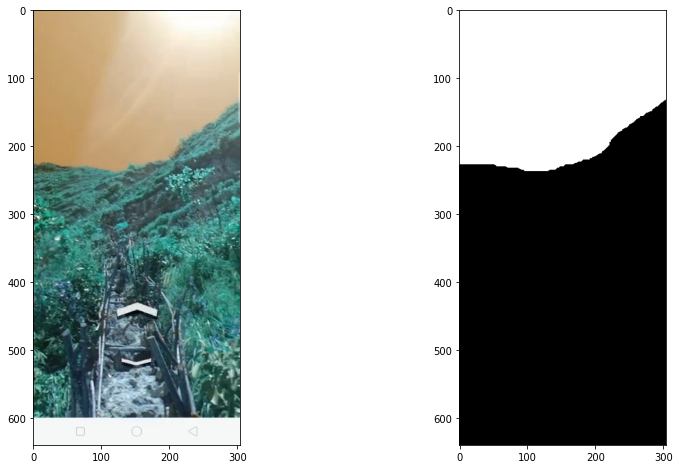

In [ ]:
import cv2
import random
import matplotlib.pyplot as plt

images_path = os.path.join(custom_data_path, "images")
masks_path = os.path.join(custom_data_path, "masks")
images_list = [ os.path.join(images_path , path) for path in os.listdir(images_path)]

idx = random.randint(0, len(images_list))
image_path = images_list[idx]
image = cv2.imread( image_path )

mask_paths = [os.path.join(masks_path, path) for path in os.listdir(masks_path) if image_path.split("/")[-1].split(".")[0] in path]

mask = cv2.imread( mask_paths[0] )

fig, axes = plt.subplots(1,2, figsize=(14,8))
axes[0].imshow(image)
axes[1].imshow(mask)

In [ ]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images_list,masks_list, transform=None):
        self.path_list = [{"image":image_path,
                           "mask": { path.split("_")[-1].split(".")[0] :path for path in masks_list if image_path.split("/")[-1].split(".")[0] in path} } for image_path in images_list]
        self.transform = transform

    def __len__(self):
        return len(self.path_list)

    def __getitem__(self,idx):

        data = self.path_list[idx]
        #print(data)

        org_image = cv2.imread(data["image"])

        if "sky" in data["mask"].keys():
            sky = cv2.imread(data["mask"]["sky"],0)
        else:
            sky = np.zeros(org_image.shape[:2] , org_image.dtype)
        
        if self.transform is not None:
            transformed = self.transform({"image": org_image, "mask": sky})
        else:
            transformed = {"image": org_image, "mask": sky}

        return transformed

def collate(batch):
    batch_size = len(batch)

    imgs = []
    msks = []
    for b in batch:
        imgs.append(b["image"])
        msks.append(b["mask"])

    imgs = torch.cat(imgs)
    msks = torch.cat(msks)

    return {"images": imgs,
            "masks": msks}

In [ ]:
import yaml
import random
import preprocess as pp
from torch.utils.data import DataLoader

with open("config.yaml") as f:
    config = yaml.load(f)

images_list = [ os.path.join(images_path , path) for path in os.listdir(images_path)]
masks_list = [ os.path.join(masks_path , path) for path in os.listdir(masks_path)]

split = int(abs(0.8*len(images_list)))
train_images_list = images_list[:split]

val_images_list = images_list[split:]

mean = config["train"]["normalize"]["imagenet"]["mean"]
std = config["train"]["normalize"]["imagenet"]["std"]

transform = {"train" : pp.Compose([pp.Rescale((512,720)),
                     pp.RandomCrop(512,True),
                     pp.Normalize_Image_and_Correct_Mask(mean,std)]),
            "val" : pp.Compose([pp.Rescale((512,512)),
                                pp.Normalize_Image_and_Correct_Mask(mean,std)]) }

train_dataset = CustomDataset(train_images_list,masks_list,transform["train"])
val_dataset = CustomDataset(val_images_list,masks_list, transform["val"])

batch_size = 8 #config["train"]["batch_size"]

train_dl = DataLoader(train_dataset,
                     batch_size=batch_size,
                     shuffle=True,
                      collate_fn = collate)

val_dl = DataLoader(val_dataset,
                    batch_size= batch_size,
                    collate_fn = collate)

In [ ]:
print("Training Data ",len(train_dataset))
print("Validation Data ",len(val_dataset))

Training Data  975
Validation Data  244


In [ ]:
import numpy as np

# DeNormalization of Tensor
def deNormalize(tensor,mean,std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
# Get a Batch from DataLoader
it = iter(train_dl)


In [ ]:
print(len(train_dataset),len(val_dataset))
x = next(it)
print(x["images"].shape, x["masks"].shape)

975 244
torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])


In [ ]:
for num,mask in enumerate(x["masks"]):
    print(num, torch.unique(mask))

0 tensor([0, 1])
1 tensor([0, 1])
2 tensor([0, 1])
3 tensor([0, 1])
4 tensor([0, 1])
5 tensor([0, 1])
6 tensor([0, 1])
7 tensor([0])


In [ ]:
# select an instance of a batch and denormalize it
img = x["images"][0]
msk = x["masks"][0]
print(img.shape, msk.shape)
print(img.min() , img.max())

dn_img = deNormalize(img, mean, std)
print( dn_img.min(), dn_img.max())

torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
tensor(-2.1179) tensor(1136.3572)
tensor(0.) tensor(255.0000)


(512, 512, 3)
torch.Size([512, 512])


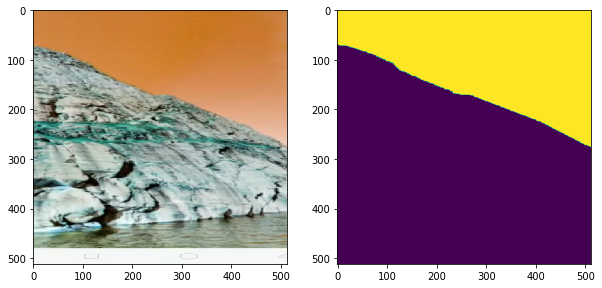

In [ ]:
# plot denormalized data instance
import utils
import numpy as np
image = np.array( np.floor( np.transpose(dn_img , (1,2,0)))).astype(np.int64)
print(image.shape)
mask = np.squeeze(msk, 0)
print(mask.shape)
fig , axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].imshow( image )
axes[1].imshow( mask )

In [ ]:
import torch
import segmentation_models_pytorch as smp

model_path = "/content/drive/My Drive/sky_model_baseline.pt" 
model = torch.load(model_path)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
epochs = 50
save_path = "/content/drive/My Drive/SS/models/SS_CustomData1200_resnet34.pt" #config["train"]["save_path"]

In [ ]:
import loss
from tqdm.notebook import tqdm
import time
from torch.autograd import Variable

def train():
    best_loss = np.inf
    cnt_since_last_improvement = 0
    patience = 10
    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch , epochs-1))
        print("=="*10)
        start = time.time()
        

        model.train()
        sum_bce_loss = 0.0
        #sum_dice_loss = 0.0
        #sum_total_loss = 0.0
        #sum_iou = 0.0
        num = 0.0
        
        for sample in tqdm(train_dl):
            
            inputs = sample['images'].to(device)
            target = utils.expand_target( sample['masks'].to(device) )

            #print(target.size())
            
            optimizer_ft.zero_grad()
            output = model(inputs)
            #print(output.size())

            bce_loss = loss.bce_loss(output, target.float() )
            #dice_loss = loss.dice_loss(output, target.float() )
            #total_loss = loss.BCEDiceLoss(output, target.float())
            #iou = loss.IOUScore(output, target.float())
            
            bce_loss.backward() #total_loss.backward()
            optimizer_ft.step()

            sum_bce_loss += float(bce_loss)
            #sum_dice_loss += float(dice_loss)
            #sum_total_loss += float(total_loss)
            #sum_iou += float(iou)
            num += inputs.size(0)
        #print("Train :: ","Total loss",sum_total_loss/num ,"*","BCE ",sum_bce_loss/num,"*","Dice ",sum_dice_loss/num)
        print("Train BCE loss ",sum_bce_loss/num)
        
        model.eval()
        sum_bce_loss = 0.0
        #sum_dice_loss = 0.0
        #sum_total_loss = 0.0
        #sum_iou = 0.0
        num = 0.0
        
        for sample in tqdm(val_dl):

            inputs = sample['images'].to(device)
            target = utils.expand_target( sample['masks'].to(device) )

            
            output = model(inputs)
            bce_loss = loss.bce_loss(output, target.float() )
            #dice_loss = loss.dice_loss(output, target.float() )
            #total_loss = loss.BCEDiceLoss(output, target.float())
            #iou = loss.IOUScore(output, target.float())

            sum_bce_loss += float(bce_loss)
            #sum_dice_loss += float(dice_loss)
            #sum_total_loss += float(total_loss)
            #sum_iou += float(iou)
            num += inputs.size(0)
            
        #print("Validation :: ","Total loss",sum_total_loss/num ,"*","BCE ",sum_bce_loss/num,"*","Dice ",sum_dice_loss/num)
        print("Validation BCE loss ", sum_bce_loss/num)

        cnt_since_last_improvement += 1

        if sum_bce_loss/num < best_loss:
            cnt_since_last_improvement = 0
            print("Saving Best Model")
            best_loss = sum_bce_loss/num
            torch.save(model, save_path)

        print("Epoch time ",(time.time() - start)//60,"minutes")
        print("Best Validation Loss ", best_loss)

        if cnt_since_last_improvement >= patience:
            print("================> Early Stopping! <=================")
            break
        


In [ ]:
model.to(device)
train()

Epoch 0/49



Train BCE loss  0.2046483254738343



Validation BCE loss  0.159810905024165
Saving Best Model
Epoch time  4.0 minutes
Best Validation Loss  0.159810905024165
Epoch 1/49



Train BCE loss  0.11014990827976129



Validation BCE loss  0.12769917618544374
Saving Best Model
Epoch time  4.0 minutes
Best Validation Loss  0.12769917618544374
Epoch 2/49



Train BCE loss  0.1038411189806767



Validation BCE loss  0.1509886734554025
Epoch time  4.0 minutes
Best Validation Loss  0.12769917618544374
Epoch 3/49



Train BCE loss  0.10633969994691703



Validation BCE loss  0.10031161170269622
Saving Best Model
Epoch time  4.0 minutes
Best Validation Loss  0.10031161170269622
Epoch 4/49



Train BCE loss  0.10109263765506256



Validation BCE loss  0.1001767990652655
Saving Best Model
Epoch time  4.0 minutes
Best Validation Loss  0.1001767990652655
Epoch 5/49



Train BCE loss  0.09506118355653224



Validation BCE loss  0.10202415543990057
Epoch time  4.0 minutes
Best Validation Loss  0.1001767990652655
Epoch 6/49



Train BCE loss  0.09244016786416372



Validation BCE loss  0.09154654807243191
Saving Best Model
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 7/49



Train BCE loss  0.08765783656866123



Validation BCE loss  0.1098762224199342
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 8/49



Train BCE loss  0.09869432539511949



Validation BCE loss  0.18470703645563516
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 9/49



Train BCE loss  0.09882424797767247



Validation BCE loss  0.21463669665524218
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 10/49



Train BCE loss  0.08852577863595425



Validation BCE loss  0.09697171728141972
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 11/49



Train BCE loss  0.0822864708227989



Validation BCE loss  0.1401457095854595
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 12/49



Train BCE loss  0.08294361777794666



Validation BCE loss  0.1000065378478316
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 13/49



Train BCE loss  0.07432628504740886



Validation BCE loss  0.11036864759736374
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 14/49



Train BCE loss  0.07489930177346255



Validation BCE loss  0.10733251353023482
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 15/49



Train BCE loss  0.07481795382805359



Validation BCE loss  0.12440995792629289
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
Epoch 16/49



Train BCE loss  0.07655329294693776



Validation BCE loss  0.11046972339514827
Epoch time  4.0 minutes
Best Validation Loss  0.09154654807243191
================> Early Stopping! <=================


In [ ]:
import torch
save_path = "/content/drive/My Drive/SS/models/SS_CustomData1200_resnet34.pt" #config["train"]["save_path"]
model = torch.load(save_path,map_location = torch.device('cpu') )

In [ ]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import functional
import utils

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def predict(image_path, model):
    org_img = cv2.imread(image_path)
    org_shape = org_img.shape[:2]
    resized = cv2.resize(org_img, (512,512), interpolation=cv2.INTER_NEAREST)
    transposed = np.transpose(resized, (2, 0, 1))
    image_tensor = torch.from_numpy(transposed).float()
    image = functional.normalize(image_tensor, mean, std)
    image = image[None,...]
    pred = model(image)
    pred_mask = torch.round(torch.sigmoid(pred))[0][0]
    pred_mask = cv2.resize(pred_mask.detach().numpy(), (org_shape[1],org_shape[0] ), interpolation=cv2.INTER_NEAREST)
    return {"image": org_img, "mask": pred_mask}

def show(sample):
    fig, axes = plt.subplots(1,2 ,figsize=(10,6))
    axes[0].imshow(sample["image"])
    axes[1].imshow(sample["mask"])
    plt.show()

def save_mask(sample, image_path, mask_path):
    """
    Save the mask on mask_path with name as image_name + "_mask.jpg"
    """
    to_save_ = np.float32( utils.correct_binary( sample["mask"], True) )
    filename = os.path.join( mask_path , image_path.split("/")[-1].split(".")[0] + "_mask" + ".jpg" )
    cv2.imwrite(filename, to_save_)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


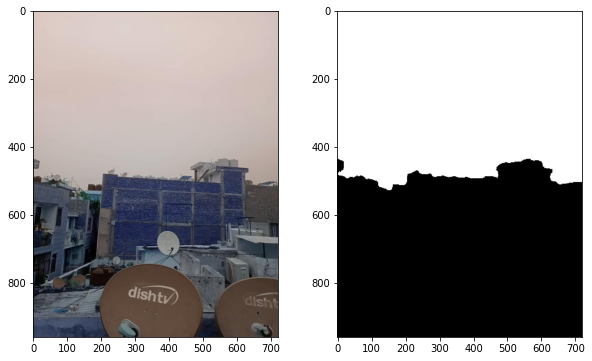

In [ ]:
import os
import numpy as np
import random
unzipped_images_path = "/content/drive/My Drive/unzipped/images"
unzipped_images = os.listdir("/content/drive/My Drive/unzipped/images")
unzipped_masks_path = "/content/drive/My Drive/unzipped/masks"


def save_unzipped_masks():
    for image_name in tqdm(unzipped_images):
        image_path = os.path.join(unzipped_images_path, image_name)
        sample = predict(  image_path , model )
        save_mask(sample, image_path, unzipped_masks_path)

save_unzipped_masks()

def get_mask_name(image_name, masks_path):
    unzipped_masks = os.listdir(masks_path)
    for path in unzipped_masks:
        if image_name.split(".")[0] in path:
            return path

idx = random.randint(0, len(unzipped_images))
data = [ (image_name, get_mask_name(image_name, unzipped_masks_path) ) for image_name in unzipped_images]
datum = data[idx]
image = cv2.imread( os.path.join(unzipped_images_path, datum[0]) )
mask = cv2.imread( os.path.join(unzipped_masks_path, datum[1]) )

show({"image":image, "mask":mask})

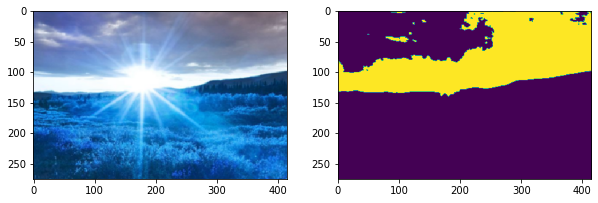

In [ ]:
sample = predict("w1.png",model)
show(sample)

In [ ]:
val_iter = iter(val_dl)

In [ ]:
sample = next(val_iter)

In [ ]:
import random
idx = random.randint(0, sample["images"].shape[0] )
pred = model(sample["images"])
pred_mask = torch.round(torch.sigmoid(pred))[idx][0]

img = sample["images"][idx]
msk = sample["masks"][idx]
print(img.shape, msk.shape)
print(img.min() , img.max())

dn_img = deNormalize(img, mean, std)
print( dn_img.min(), dn_img.max())

torch.Size([3, 128, 128]) torch.Size([1, 128, 128])
tensor(-2.1179) tensor(1082.7858)
tensor(0.) tensor(243.0000)


(128, 128, 3)
torch.Size([128, 128])


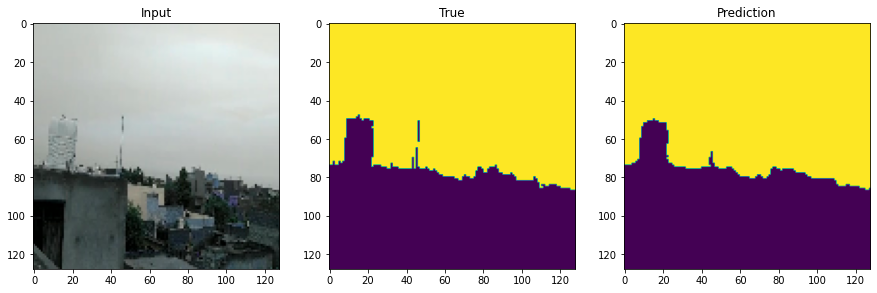

In [ ]:

import utils
import numpy as np
image = np.array( np.floor( np.transpose(dn_img , (1,2,0)))).astype(np.int64)
print(image.shape)
mask = np.squeeze(msk, 0)
print(mask.shape)
fig , axes = plt.subplots(1, 3, figsize=(15,6))

axes[0].set_title("Input")
axes[0].imshow( image )
axes[1].set_title("True")
axes[1].imshow( utils.correct_binary(mask, True) )
axes[2].set_title("Prediction")
axes[2].imshow( pred_mask.cpu().detach().numpy())

In [ ]:
import zipfile

imgs = "/content/drive/My Drive/unzipped/images"
msks = "/content/drive/My Drive/unzipped/masks"
if not os.path.exists(imgs):
    os.makedirs(imgs)
if not os.path.exists(msks):
    os.makedirs(msks)

with zipfile.ZipFile("1595035802599 (7-20-2020 6-28-32 AM).zip", 'r') as zip_ref:
    zip_ref.extractall(imgs)

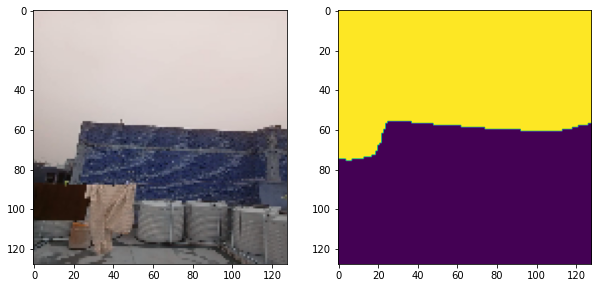